##### Dependencies

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
!kaggle competitions download -c playground-series-s4e7
!unzip /content/playground-series-s4e7.zip -d /content/playground-series-s4e7_data/
## api.competitions_data_download_files('playground-series-s4e7')
## api.dataset_download_files(, path='playground-series-s4e7', unzip=True)

 93% 229M/247M [00:02<00:00, 97.4MB/s]
100% 247M/247M [00:02<00:00, 114MB/s] 
Archive:  /content/playground-series-s4e7.zip
  inflating: /content/playground-series-s4e7_data/sample_submission.csv  
  inflating: /content/playground-series-s4e7_data/test.csv  
  inflating: /content/playground-series-s4e7_data/train.csv  


In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# SVM?
# Random Forest?
# XGBoost?

In [4]:
data = pd.read_csv('/content/playground-series-s4e7_data/train.csv', index_col="id")

In [5]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

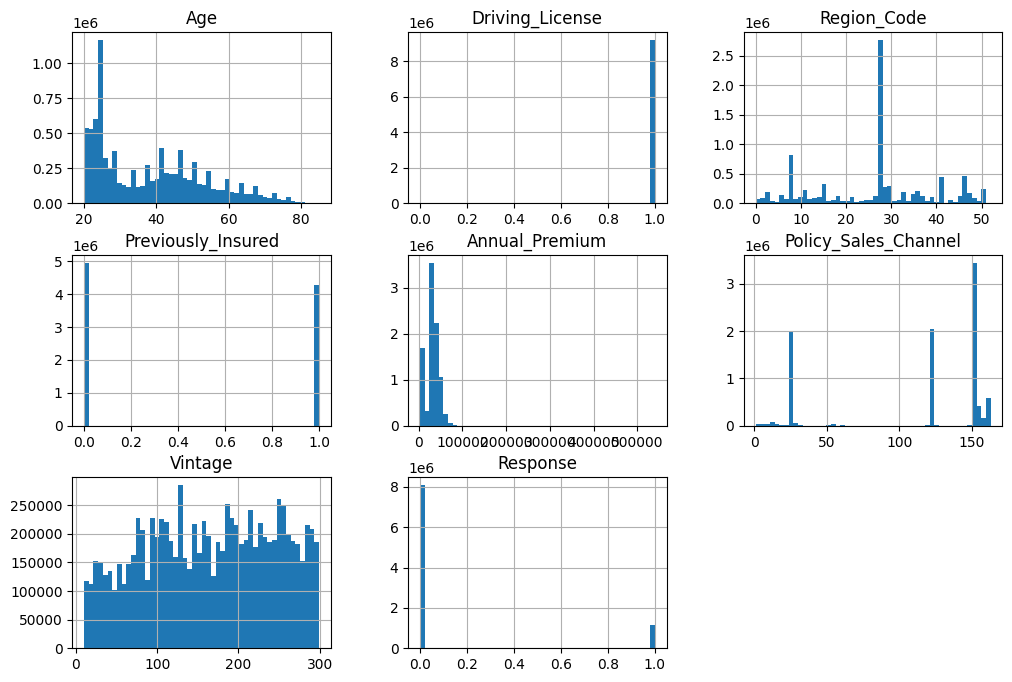

In [14]:
train.hist(bins=50, figsize=(12,8))
plt.show()

(array([2.649500e+04, 4.000000e+00, 0.000000e+00, 1.119000e+04,
        1.066300e+04, 1.000000e+00, 3.542200e+04, 3.305600e+04,
        4.325000e+03, 3.170200e+04, 1.698100e+04, 5.695500e+04,
        2.879800e+04, 3.576000e+03, 4.987000e+03, 1.009000e+04,
        7.153400e+04, 1.946200e+06, 1.887700e+04, 4.579600e+04,
        1.096000e+03, 3.826000e+03, 1.260000e+02, 3.773000e+03,
        1.576000e+03, 2.880000e+02, 2.706600e+04, 3.174500e+04,
        2.797500e+04, 1.455000e+03, 1.051000e+03, 1.210000e+02,
        1.870000e+02, 5.770000e+02, 5.300000e+01, 1.214000e+03,
        4.260000e+03, 8.960000e+02, 1.768000e+03, 2.115000e+03,
        6.582000e+03, 3.868000e+03, 2.464440e+05, 1.838943e+06,
        5.369000e+03, 1.016500e+04, 5.413000e+03, 1.017330e+05,
        3.923657e+06, 5.938440e+05]),
 array([ 1.        ,  1.23534291,  1.47068581,  1.70602872,  1.94137163,
         2.17671453,  2.41205744,  2.64740035,  2.88274325,  3.11808616,
         3.35342907,  3.58877197,  3.82411488,  

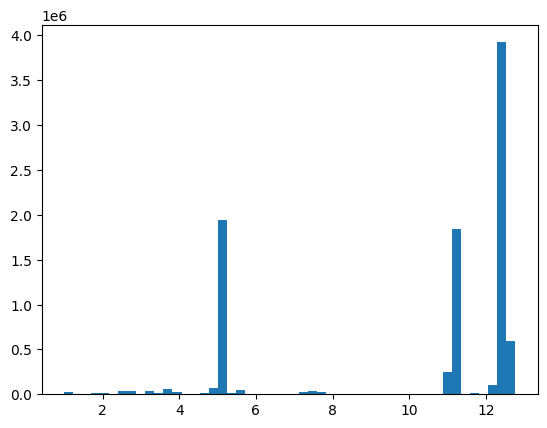

In [31]:
import numpy as np
plt.hist(train["Policy_Sales_Channel"]**0.5, bins=50)

##### Preprocessing

In [6]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df.Region_Code = df.Region_Code.astype("int8")

    df.Previously_Insured = df.Previously_Insured.astype("int8")

    df.Driving_License = df.Driving_License.astype("int8")

    df.Gender = df.Gender.map({"Male": 1, "Female": 0})

    df.Vehicle_Damage = df.Vehicle_Damage.map({"Yes": 1, "No": 0})

    vehicle_age = pd.get_dummies(df.Vehicle_Age, drop_first=True)
    df[["< 1 Year", "> 2 Years"]] = vehicle_age
    df.drop(columns="Vehicle_Age", inplace=True)

    # region_dummies = pd.get_dummies(df.Region_Code, drop_first=True)
    # regions = pd.get_dummies(df.Region_Code, drop_first=True)
    # df.drop(columns="Region_Code", inplace=True)
    # df = pd.concat([df, regions], axis=1)
    return df

In [7]:
train = clean_data(train)

In [9]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,< 1 Year,> 2 Years
id,,,,,,,,,,,,
2405201,0,41,1,33,0,1,38803.0,124.0,162,0,False,False
7069408,1,24,1,49,0,1,2630.0,152.0,282,0,True,False
1044712,1,39,1,11,0,1,31271.0,124.0,229,0,False,False
6286832,1,52,1,8,1,0,34394.0,26.0,129,0,False,False
5807645,0,69,1,41,1,0,30584.0,124.0,113,0,False,False


In [10]:
independent_vars = [col for col in train.columns if col not in ["Response", "Region_Code"]]
features = train[independent_vars]
response = train.Response
# features.columns = features.columns.astype(str)

In [ ]:
features.head()

In [11]:
# Standardise Features
# Region_Code to be dummified, Annual_premium, Policy_sales_Channel, Vintage
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features[["Annual_Premium", "Policy_Sales_Channel", "Vintage"]])
features[["Annual_Premium", "Policy_Sales_Channel", "Vintage"]] = scaled_array

<ipython-input-11-c329643a6133>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[["Annual_Premium", "Policy_Sales_Channel", "Vintage"]] = scaled_array


In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, response)


In [13]:
logreg = LogisticRegression()
logreg.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
import pickle
with open("logreg_no_region_code.pkl", "wb") as f:
    pickle.dump(logreg, f, protocol=5)

In [ ]:
pipeline = Pipeline([("scaler", premium_scaler), ("logreg", logreg)])

NameError: name 'premium_scaler' is not defined

In [14]:
test = clean_data(test)

In [15]:
scaled_array = scaler.transform(test[["Annual_Premium", "Policy_Sales_Channel", "Vintage"]])
test[["Annual_Premium", "Policy_Sales_Channel", "Vintage"]] = scaled_array

In [ ]:
# pipeline.transform(test).score()
# scaled_premium = premium_scaler.transform(test.Annual_Premium.values.reshape(-1,1))
# test.Annual_Premium = scaled_premium

In [16]:
y_pred = logreg.predict(test[independent_vars])

In [17]:
roc_auc_score(test["Response"], y_pred)

0.7857823189442626

In [ ]:
# ROC AUC with resampled classes to avoid imbalance = 0.77
# ROC AUC without resmapling = 0.5, as bad as it gets

In [ ]:
logreg.coef_

array([[ 0.08458402, -0.437915  ,  1.06531874,  4.02148074, -0.16459027,
        -1.31185652,  0.28715447]])